In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import os
import sys
import torch
import torch.nn as nn
from omegaconf import OmegaConf
from monai.metrics import DiceMetric
from sklearn import metrics
from torch.utils.data import DataLoader
from matplotlib.patches import Ellipse

In [2]:
REPO_PATH = "/workspace/repositories/DSSQ/src"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
sys.path.append(REPO_PATH)

from models import get_unet
from data_utils import get_eval_data
from adapters import DimReductAdapter, DimReductModuleWrapper

### Load basic config
# DATA_KEY = "heart"
DATA_KEY = "prostate"
LOG = False
LOAD_ONLY_PRESENT = True
VALIDATION = True  # If false makes validation set be the training one
EXTRA_DESCRIPTION = "_base"
MODE = "eval"
N_DIMS = [32, 960]
models = ["monai-64-4-4", "swinunetr"]
train_vendors = ["siemens"]
test_vendors = ["siemens", "philips", "ge"]
dim_red_modes = ["IPCA", "PCA", "AVG_POOL"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_conf(unet_name="", iteration=0, data_key="prostate"):
    cfg = OmegaConf.load(f"{REPO_PATH}/configs/conf.yaml")
    OmegaConf.update(cfg, "run.iteration", iteration)
    OmegaConf.update(cfg, "run.data_key", data_key)
    args = unet_name.split("-")
    cfg.wandb.log = LOG
    cfg.unet[data_key].pre = unet_name
    cfg.unet[data_key].arch = args[0]
    cfg.unet[data_key].n_filters_init = int(args[1]) if "monai" in unet_name else None
    cfg.unet[data_key].training.load_only_present = LOAD_ONLY_PRESENT
    cfg.unet[data_key].training.validation = VALIDATION
    cfg.unet[data_key].training.batch_size = 32
    cfg.wandb.project = f"{data_key}_{unet_name}_{iteration}{EXTRA_DESCRIPTION}"
    if MODE == "eval":
        cfg.format = "numpy"
    layer_names = None
    if "monai" in unet_name:
        cfg.unet[data_key].depth = int(args[2])
        cfg.unet[data_key].num_res_units = int(args[3])
        layer_names = [
            f'model.{"1.submodule." * i}0.conv' for i in range(cfg.unet[DATA_KEY].depth)
        ]
        layer_names.append("model.1.submodule.1.submodule.2.0.conv")
    elif unet_name == "swinunetr":
        layer_names = ["encoder2", "encoder3", "encoder4", "encoder10"]
    return cfg, layer_names

@torch.no_grad()
def eval_data(cfg, model, dataset):
    if hasattr(model, "empty_data"):
        model.empty_data()
    model.eval()
    dice_scores = []
    seg_masks = []
    dm = DiceMetric(ignore_empty=True, include_background=False)
    dataloader = DataLoader(
        dataset,
        batch_size=cfg.unet.prostate.training.batch_size,
        shuffle=False,
        drop_last=False,
    )
    for batch in dataloader:
        input_ = batch["input"].cuda()
        target = batch["target"]
        out = model(input_)
        seg_mask = torch.argmax(out, dim=1).unsqueeze(1)
        batch_dices = dm(seg_mask.detach().cpu(), target)
        seg_masks.append(seg_mask)
        dice_scores.append(batch_dices)

    dice_scores = torch.cat(dice_scores, dim=0).squeeze().detach().cpu().numpy()
    seg_masks = torch.cat(seg_masks, dim=0).detach().cpu()
    return dice_scores, seg_masks

monai_iter = 1
swin_iter = 0

#### Collect dice and segmentation masks data

In [3]:
all_eval_data = {}
dices_vendor = {}

for ven in train_vendors:
    dices_vendor[f"{ven}_train"] = {}
    cfg, _ = load_conf(data_key=DATA_KEY)
    cfg.unet[DATA_KEY].training.subset = "training"
    cfg.unet[DATA_KEY].training.vendor = ven
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    all_eval_data[f"{ven}_train"] = data['eval']
    for model in models:
        dices_vendor[f"{ven}_train"][model] = {}
        if "monai" in model:
            iteration = monai_iter
        else:
            iteration = swin_iter
        cfg, layer_names = load_conf(model, iteration=iteration, data_key=DATA_KEY)
        model_base, state_dict = get_unet(cfg, return_state_dict=True)
        model_base = model_base.to(device)
        model_base.eval()
        adapters = [
            DimReductAdapter(layer_name, 2, cfg.unet[DATA_KEY].training.batch_size,
                             mode="PCA", pre_fit=True, fit_gaussian=True,
                             project=cfg.wandb.project
                             ) for layer_name in layer_names
        ]
        adapters = nn.ModuleList(adapters)
        model_adapted = DimReductModuleWrapper(model=model_base, adapters=adapters)
        model_adapted = model_adapted.to(device)
        model_adapted.eval()
        model_base_dices, model_base_segs = eval_data(cfg, model_adapted, data["eval"])
        dices_vendor[f"{ven}_train"][model]['DS'] = model_base_dices
        dices_vendor[f"{ven}_train"][model]['seg'] = model_base_segs
        dices_vendor[f"{ven}_train"][model]['dim_red_features'] = {adapter.swivel: np.vstack(adapter.reduced_acts) for adapter in model_adapted.adapters}

for ven in test_vendors:
    dices_vendor[ven] = {}
    cfg, _ = load_conf(data_key=DATA_KEY)
    cfg.unet[DATA_KEY].training.subset = (
        "validation" if ven in train_vendors else False
    )
    cfg.unet[DATA_KEY].training.vendor = ven
    data = get_eval_data(eval_set=True, cfg=cfg)
    all_eval_data[ven] = data['eval']
    for model in models:
        dices_vendor[ven][model] = {}
        if "monai" in model:
            iteration = monai_iter
        else:
            iteration = swin_iter
        cfg, layer_names = load_conf(model, iteration=iteration, data_key=DATA_KEY)
        model_base, state_dict = get_unet(cfg, return_state_dict=True)
        model_base = model_base.to(device)
        model_base.eval()
        adapters = [
            DimReductAdapter(layer_name, 2, cfg.unet[DATA_KEY].training.batch_size,
                             mode="PCA", pre_fit=True, fit_gaussian=True,
                             project=cfg.wandb.project
                             ) for layer_name in layer_names
        ]
        adapters = nn.ModuleList(adapters)
        model_adapted = DimReductModuleWrapper(model=model_base, adapters=adapters)
        model_adapted = model_adapted.to(device)
        model_adapted.eval()
        model_base_dices, model_base_segs = eval_data(cfg, model_adapted, data["eval"])
        dices_vendor[ven][model]['DS'] = model_base_dices
        dices_vendor[ven][model]['seg'] = model_base_segs
        dices_vendor[ven][model]['dim_red_features'] = {adapter.swivel: np.vstack(adapter.reduced_acts) for adapter in model_adapted.adapters}

Loading evaluation PMRI dataset for vendor siemens ...
Loaded model from epoch 66 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_1_base_1_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 38 and path:
/workspace/out/weights/prostate_swinunetr_prostate_swinunetr_0_base_0_best.pt
Loading evaluation PMRI dataset for vendor siemens ...
Loaded model from epoch 66 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_1_base_1_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 38 and path:
/workspace/out/weights/prostate_swinunetr_prostate_swinunetr_0_base_0_best.pt
Loading evaluation PMRI dataset for vendor philips ...
Loaded model from epoch 66 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_1_base_1_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 38 and path:
/workspace/out/weights/prostate_swinunetr_prostate_swinunetr_0_base_0_best.pt
Loading evaluation PMRI dataset for vendor ge ...
Loaded model from epoch 66 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_1_base_1_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 38 and path:
/workspace/out/weights/prostate_swinunetr_prostate_swinunetr_0_base_0_best.pt


#### Collect Mahalanobis Distance data

In [4]:
@torch.no_grad()
def eval_pmri_MD(cfg, model, dataset):
    ''' Mahalanobis distance (MD) evaluation '''
    assert isinstance(model, DimReductModuleWrapper), "Model must be a DimReductModuleWrapper"
    model.empty_data()
    model.eval()
    dataloader = DataLoader(dataset, batch_size=cfg.unet.prostate.training.batch_size,
                            shuffle=False, drop_last=False)
    for batch in dataloader:
        input_ = batch['input']
        model(input_.cuda())

    md = {adapter.swivel: torch.cat(adapter.distances, dim=0).detach().cpu() for adapter in model.adapters}
    return md

for ven in train_vendors:
    cfg, _ = load_conf(data_key=DATA_KEY)
    cfg.unet[DATA_KEY].training.subset = "training"
    cfg.unet[DATA_KEY].training.vendor = ven
    data = all_eval_data[f"{ven}_train"]
    for model in models:
        if "monai" in model:
            iteration = monai_iter
            mode = "PCA"
            n_dims = 2
        else:
            iteration = swin_iter
            mode = "AVG_POOL"
            n_dims = 1e4
        cfg, layer_names = load_conf(model, iteration=iteration, data_key=DATA_KEY)
        model_base, state_dict = get_unet(cfg, return_state_dict=True)
        model_base = model_base.to(device)
        model_base.eval()
        adapters = [
            DimReductAdapter(layer_name, n_dims, cfg.unet[DATA_KEY].training.batch_size,
                             mode=mode, pre_fit=True, fit_gaussian=False,
                             project=cfg.wandb.project
                             ) for layer_name in layer_names
        ]
        adapters = nn.ModuleList(adapters)
        model_adapted = DimReductModuleWrapper(model=model_base, adapters=adapters)
        model_adapted = model_adapted.to(device)
        model_adapted.eval()
        md_data = eval_pmri_MD(cfg, model_adapted, data)
        dices_vendor[f"{ven}_train"][model]['md'] = md_data

for ven in test_vendors:
    cfg, _ = load_conf(data_key=DATA_KEY)
    cfg.unet[DATA_KEY].training.subset = (
        "validation" if ven in train_vendors else False
    )
    cfg.unet[DATA_KEY].training.vendor = ven
    data = all_eval_data[ven]
    for model in models:
        if "monai" in model:
            iteration = monai_iter
            mode = "PCA"
            n_dims = 2
        else:
            iteration = swin_iter
            mode = "AVG_POOL"
            n_dims = 1e4
        cfg, layer_names = load_conf(model, iteration=iteration, data_key=DATA_KEY)
        model_base, state_dict = get_unet(cfg, return_state_dict=True)
        model_base = model_base.to(device)
        model_base.eval()
        adapters = [
            DimReductAdapter(layer_name, n_dims, cfg.unet[DATA_KEY].training.batch_size,
                             mode=mode, pre_fit=True, fit_gaussian=False,
                             project=cfg.wandb.project
                             ) for layer_name in layer_names
        ]
        adapters = nn.ModuleList(adapters)
        model_adapted = DimReductModuleWrapper(model=model_base, adapters=adapters)
        model_adapted = model_adapted.to(device)
        model_adapted.eval()
        md_data = eval_pmri_MD(cfg, model_adapted, data)
        dices_vendor[ven][model]['md'] = md_data

Loaded model from epoch 66 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_1_base_1_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 38 and path:
/workspace/out/weights/prostate_swinunetr_prostate_swinunetr_0_base_0_best.pt
Loaded model from epoch 66 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_1_base_1_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 38 and path:
/workspace/out/weights/prostate_swinunetr_prostate_swinunetr_0_base_0_best.pt
Loaded model from epoch 66 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_1_base_1_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 38 and path:
/workspace/out/weights/prostate_swinunetr_prostate_swinunetr_0_base_0_best.pt
Loaded model from epoch 66 and path:
/workspace/out/weights/prostate_monai-64-4-4_prostate_monai-64-4-4_1_base_1_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 38 and path:
/workspace/out/weights/prostate_swinunetr_prostate_swinunetr_0_base_0_best.pt


In [56]:
def plot_aurc_i(data, higher_conf_better=True):
    aurcs_i = {}
    fig, ax = plt.subplots(2, 4, figsize=(30, 15))
    colors = ["red", "blue", "green"]
    for i, model in enumerate(models):
        if model == "swinunetr":
            layers = ["encoder2", "encoder3", "encoder4", "encoder10"]
        else:
            layers = [f'model.{"1.submodule." * i}0.conv' for i in range(4)]
        for j, layer in enumerate(layers):
            for k, vendor in enumerate(test_vendors[::-1]):
                dices = data[vendor][model]['DS']
                risks = 1 - dices
                n_samples = len(risks)
                counts = np.arange(1, n_samples + 1)
                coverages = counts / n_samples
                confs = data[vendor][model]['md'][layer].numpy()
                # Sort by confidence scores (highest first)
                idx_sorted = np.argsort(confs)
                if higher_conf_better:
                    idx_sorted = idx_sorted[::-1]
                cum_risks = np.cumsum(risks[idx_sorted])
                selective_risks = cum_risks / counts
                # Full coverage (starting point)
                coverages = np.insert(coverages, 0, 0)
                selective_risks = np.insert(selective_risks, 0, 0)
                aurc = metrics.auc(coverages[::-1], selective_risks[::-1])
                aurcs_i[f"{vendor}_{model}_{layer}"] = aurc
                ax[i,j].plot(
                    coverages,
                    selective_risks,
                    label=f"{vendor} AURC = {aurc:.4f}",
                    color=colors[k],
                    marker="o",
                    markersize=2,
                )
                ax[i,j].fill_between(coverages, selective_risks, color=colors[k], alpha=0.3)
                ax[i,j].set_title(f"{'U-Net' if 'monai' in model else 'SwinUNETR'} - Layer {j+1}")
                ax[i,j].set_xlabel("Coverage")
                ax[i,j].set_ylabel("Selective Risk")
                ax[i,j].legend(loc="upper right")

    plt.show()
    return aurcs_i

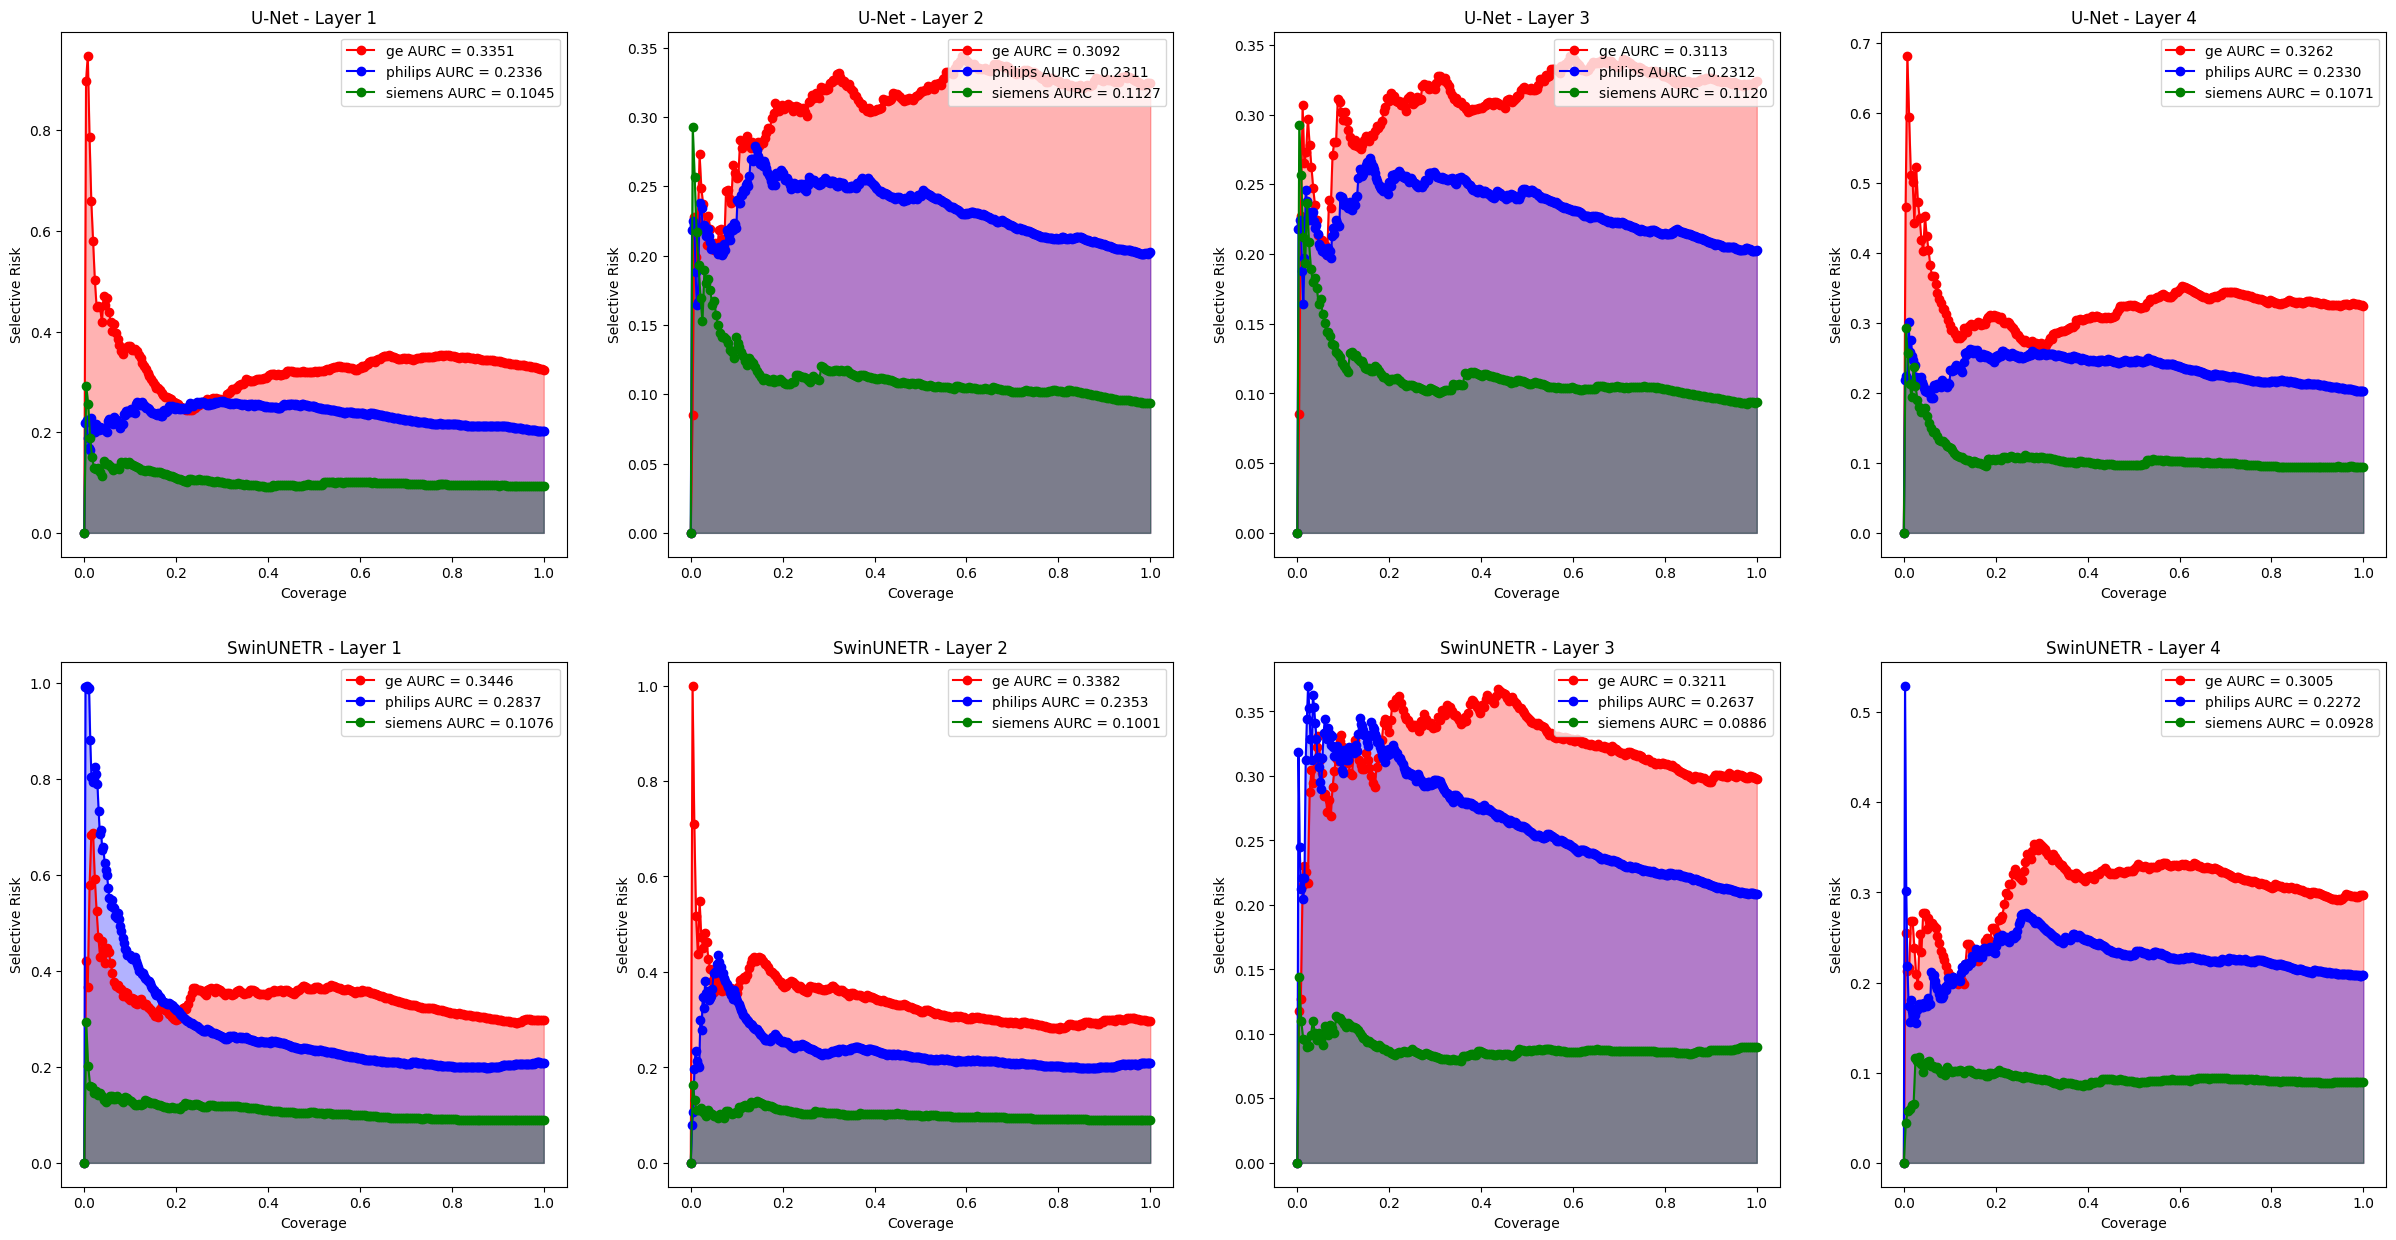

In [59]:
aurci = plot_aurc_i(dices_vendor, higher_conf_better=True)

In [27]:
def plot_multi_pca_features(data):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    colors = ['red', 'blue', 'green', 'orange']
    models = ["monai-64-4-4", "swinunetr"]
    for i, model in enumerate(models):
        if model == "monai-64-4-4":
            layers = ["model.0.conv", "model.1.submodule.1.submodule.1.submodule.0.conv"]
        else:
            layers = ["encoder2", "encoder10"]
        for j, lay in enumerate(layers):
            colors = ['red', 'blue', 'green', 'orange']
            for ven in data:
                tmp_data = dices_vendor[ven][model]["dim_red_features"][lay]
                axes[i, j].scatter(tmp_data[:, 0], tmp_data[:, 1], label=ven, color=colors.pop(), alpha=0.7)
                if "train" in ven:
                    mean = np.mean(tmp_data, axis=0)
                    std = np.std(tmp_data, axis=0)
                    ellipse1_std = Ellipse(mean, width=2*std[0], height=2*std[1], edgecolor='black', facecolor='none', linestyle='--')
                    ellipse2_std = Ellipse(mean, width=4*std[0], height=4*std[1], edgecolor='black', facecolor='none', linestyle='--')
                    axes[i,j].add_patch(ellipse1_std)
                    axes[i,j].add_patch(ellipse2_std)
                    axes[i,j].set_title(f"{'U-Net' if 'monai' in model else 'SwinUNETR'} - Layer {4**j}")
            if i == 1 and j == 0:
                axes[i,j].legend(loc="best")

    plt.tight_layout()
    plt.show()
        

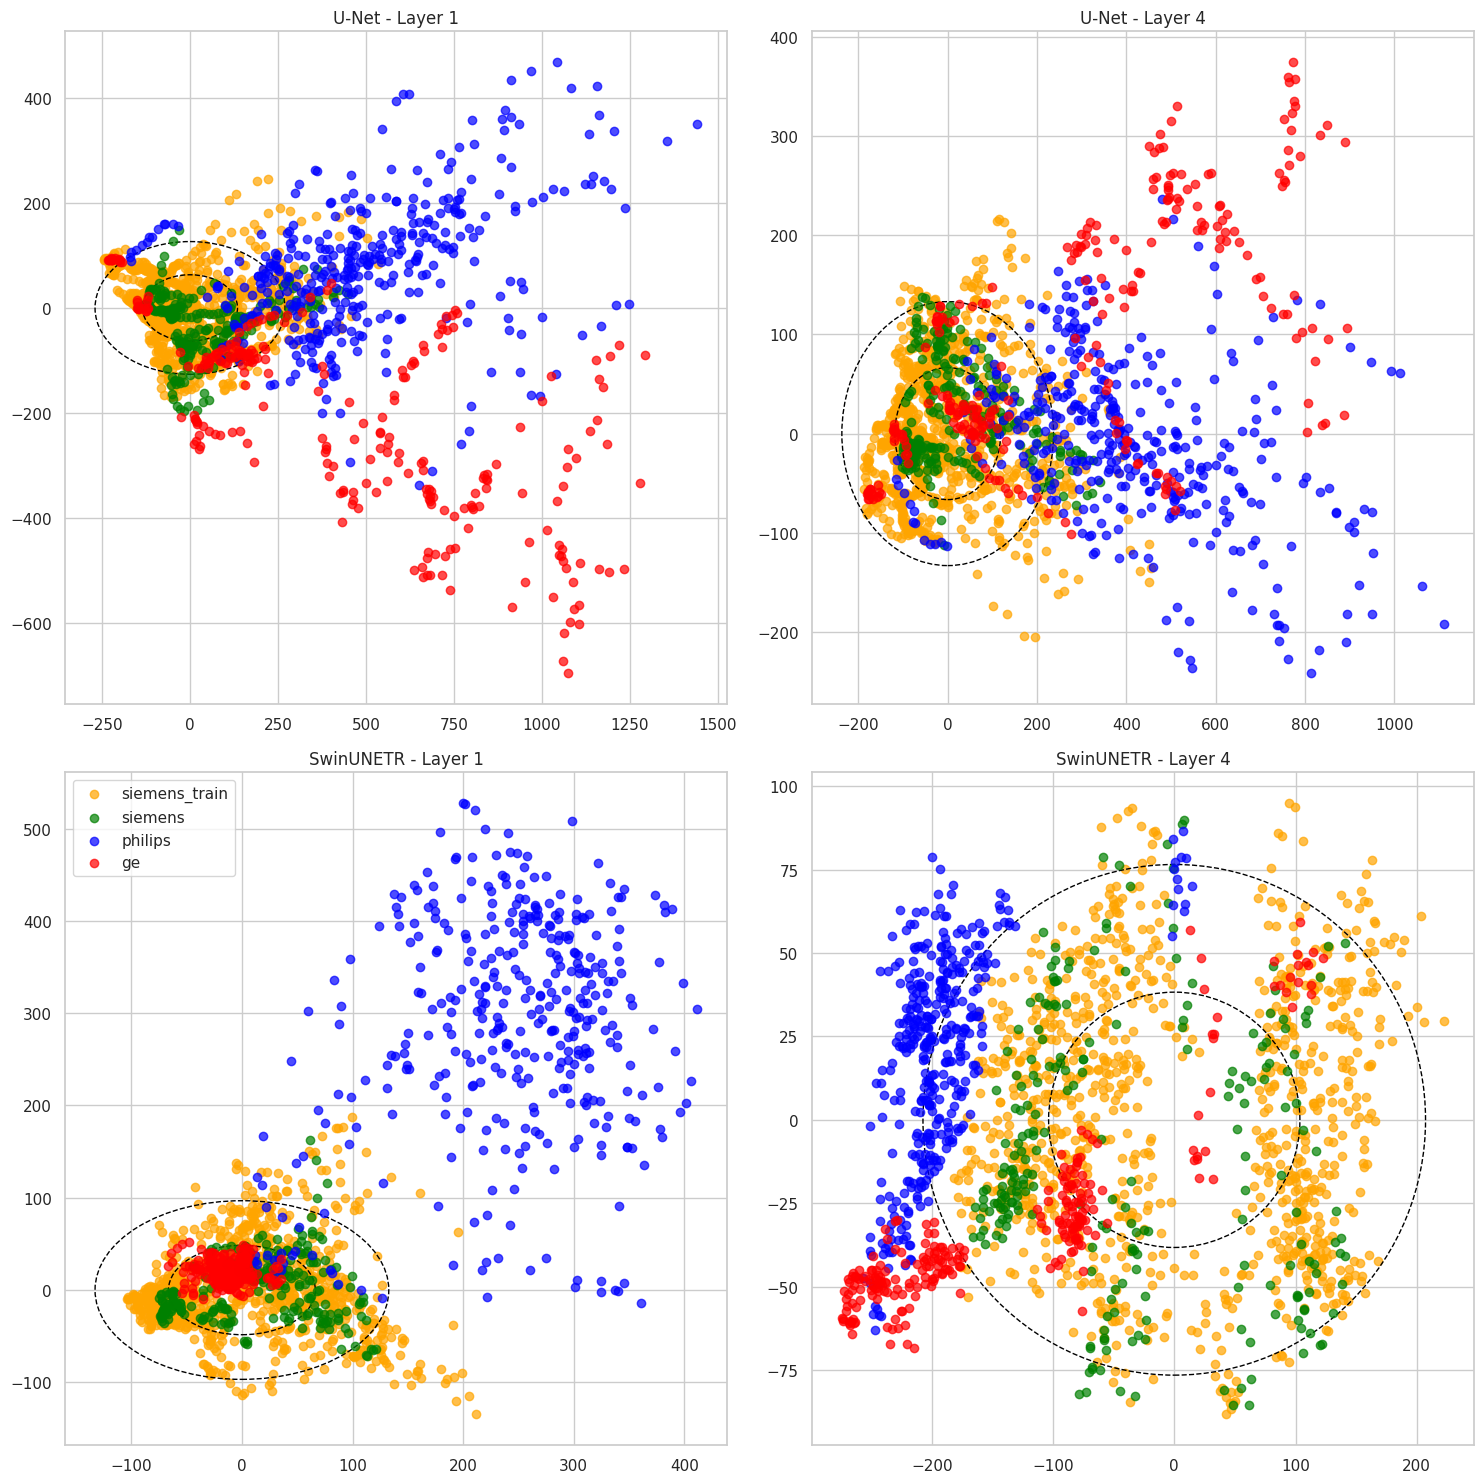

In [28]:
plot_multi_pca_features(dices_vendor)

In [5]:
def plot_pca_features(data, model, layer):
    sns.set(style="whitegrid")
    # if model == "monai-64-4-4":
    #     layer = "model.0.conv"
    # else:
    #     layer = "encoder10"
    plt.figure(figsize=(10, 10))
    colors = ['red', 'blue', 'green', 'orange']
    for ven in data:
        tmp_data = dices_vendor[ven][model]["dim_red_features"][layer]
        plt.scatter(tmp_data[:, 0], tmp_data[:, 1], label=ven, color=colors.pop(), alpha=0.7)
        if "train" in ven:
            mean = np.mean(tmp_data, axis=0)
            std = np.std(tmp_data, axis=0)
            ellipse1_std = Ellipse(mean, width=2*std[0], height=2*std[1], edgecolor='black', facecolor='none', linestyle='--')
            ellipse2_std = Ellipse(mean, width=4*std[0], height=4*std[1], edgecolor='black', facecolor='none', linestyle='--')
            plt.gca().add_patch(ellipse1_std)
            plt.gca().add_patch(ellipse2_std)

    plt.title(f"Reduced features {model} - {layer}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
        

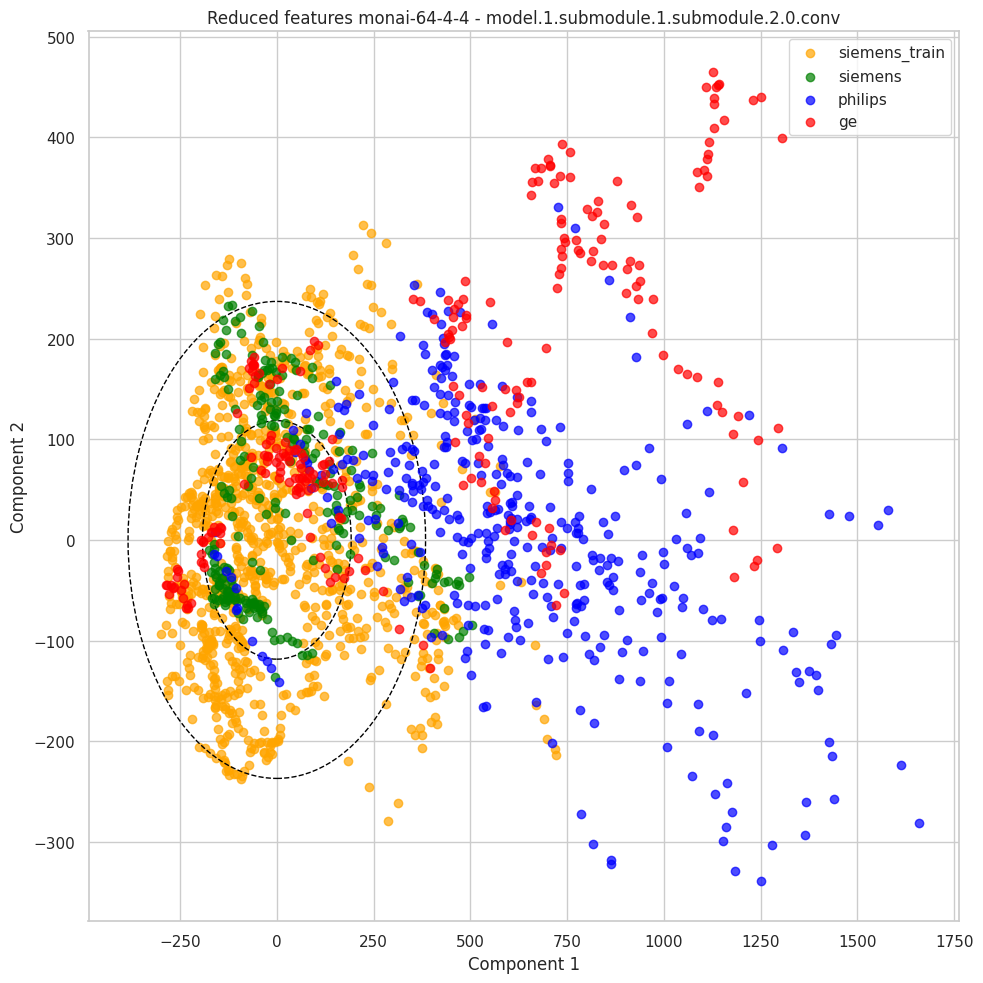

In [13]:
plot_pca_features(dices_vendor, "monai-64-4-4", "model.1.submodule.1.submodule.2.0.conv")

In [13]:
def plot_idx(idx_siem, idx_phil, idx_ge):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    i = 0
    for ven in test_vendors:
        if 'phil' in ven: arbitrary_idx = idx_phil
        elif 'siem' in ven: arbitrary_idx = idx_siem
        elif 'ge' in ven: arbitrary_idx = idx_ge
        print(ven, arbitrary_idx)
        if i == 0:
            axes[i][0].set_title('Image', fontsize=10)
            axes[i][1].set_title('Target', fontsize=10)
            axes[i][2].set_title('Predicted', fontsize=10)
            axes[i][3].set_title('Difference', fontsize=10)
            axes[i][4].set_title('Overlay', fontsize=10)
        axes[i, 0].imshow(all_eval_data[ven][arbitrary_idx]['input'][0, ...], cmap='gray')
        axes[i, 1].imshow(all_eval_data[ven][arbitrary_idx]['target'][0, ...], cmap='gray')
        img = dices_vendor[ven]['monai-64-4-4']['seg'][arbitrary_idx]
        print(ven, dices_vendor[ven]['monai-64-4-4']['DS'][arbitrary_idx])
        axes[i, 2].imshow(img[0, ...], cmap='gray')
        diff = torch.abs(img[0, ...] - all_eval_data[ven][arbitrary_idx]['target'][0, ...])
        axes[i, 3].imshow(diff, cmap='gray')
        axes[i, 4].imshow(all_eval_data[ven][arbitrary_idx]['target'][0, ...], cmap='Blues', alpha=1)
        axes[i, 4].imshow(img[0, ...], cmap='Reds', alpha=0.5)
        axes[i, 4].imshow(all_eval_data[ven][arbitrary_idx]['input'][0, ...], cmap='gray', alpha=0.7)
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        axes[i, 3].axis('off')
        axes[i, 4].axis('off')
        i += 1
    # red_patch = mpatches.Patch(color='red', label='Predicted', alpha=0.5)
    # green_patch = mpatches.Patch(color='green', label='Target', alpha=0.5)
    # plt.legend(handles=[red_patch, green_patch], loc='upper right')
    fig.text(0.1, 0.75, 'Siemens', ha='center', va='center', rotation='vertical', fontsize=10)
    fig.text(0.1, 0.45, 'Philips', ha='center', va='center', rotation='vertical', fontsize=10)
    fig.text(0.1, 0.17, 'GE', ha='center', va='center', rotation='vertical', fontsize=10)
    # plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout(rect=[0.1, 0, 1, 1])
    plt.savefig('/workspace/out/plots/seg_mask_example.png', dpi=1200, bbox_inches='tight')
    plt.show()
    

def plot_idx_2(idx_siem, idx_ge):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(2, 5, figsize=(5, 2))
    i = 0
    for ven in test_vendors:
        if 'siem' in ven: arbitrary_idx = idx_siem
        elif 'ge' in ven: arbitrary_idx = idx_ge
        else: continue
        print(ven, arbitrary_idx)
        if i == 0:
            axes[i][0].set_title('Image', fontsize=10)
            axes[i][1].set_title('Target', fontsize=10)
            axes[i][2].set_title('Predicted', fontsize=10)
            axes[i][3].set_title('Difference', fontsize=10)
            axes[i][4].set_title('Overlay', fontsize=10)
        axes[i, 0].imshow(all_eval_data[ven][arbitrary_idx]['input'][0, ...], cmap='gray')
        axes[i, 1].imshow(all_eval_data[ven][arbitrary_idx]['target'][0, ...], cmap='gray')
        img = dices_vendor[ven]['monai-64-4-4']['seg'][arbitrary_idx]
        print(ven, dices_vendor[ven]['monai-64-4-4']['DS'][arbitrary_idx])
        axes[i, 2].imshow(img[0, ...], cmap='gray')
        diff = torch.abs(img[0, ...] - all_eval_data[ven][arbitrary_idx]['target'][0, ...])
        axes[i, 3].imshow(diff, cmap='gray')
        axes[i, 4].imshow(img[0, ...], cmap='Reds', alpha=1)
        axes[i, 4].imshow(all_eval_data[ven][arbitrary_idx]['target'][0, ...], cmap='Greens', alpha=0.5)
        axes[i, 4].imshow(all_eval_data[ven][arbitrary_idx]['input'][0, ...], cmap='gray', alpha=0.7)
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        axes[i, 3].axis('off')
        axes[i, 4].axis('off')
        i += 1
    # red_patch = mpatches.Patch(color='red', label='Predicted', alpha=0.5)
    # green_patch = mpatches.Patch(color='green', label='Target', alpha=0.5)
    # plt.legend(handles=[red_patch, green_patch], loc='upper right')
    fig.text(0.1, 0.65, 'Siemens', ha='center', va='center', rotation='vertical', fontsize=10)
    fig.text(0.1, 0.25, 'GE', ha='center', va='center', rotation='vertical', fontsize=10)
    # plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout(rect=[0.1, 0, 1, 1])
    plt.savefig('/workspace/out/plots/seg_mask_example_2.png', dpi=1200, bbox_inches='tight')
    plt.show()
    

siemens 30
siemens 0.9628461
philips 25
philips 0.64910024
ge 67
ge 0.077892326


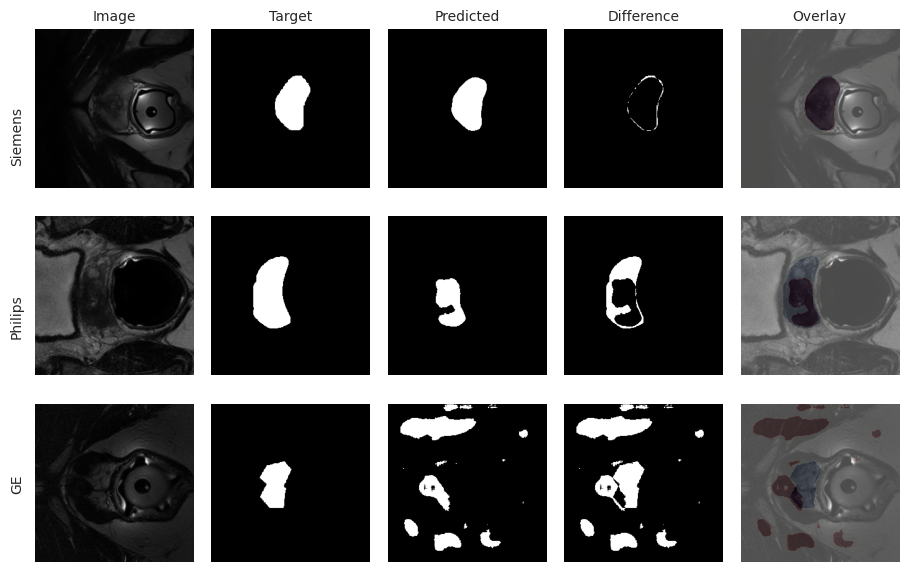

In [14]:
plot_idx(30, 25, 67)

siemens 97
siemens 0.94952613
philips 122
philips 0.66680074
ge 116
ge 0.54538655


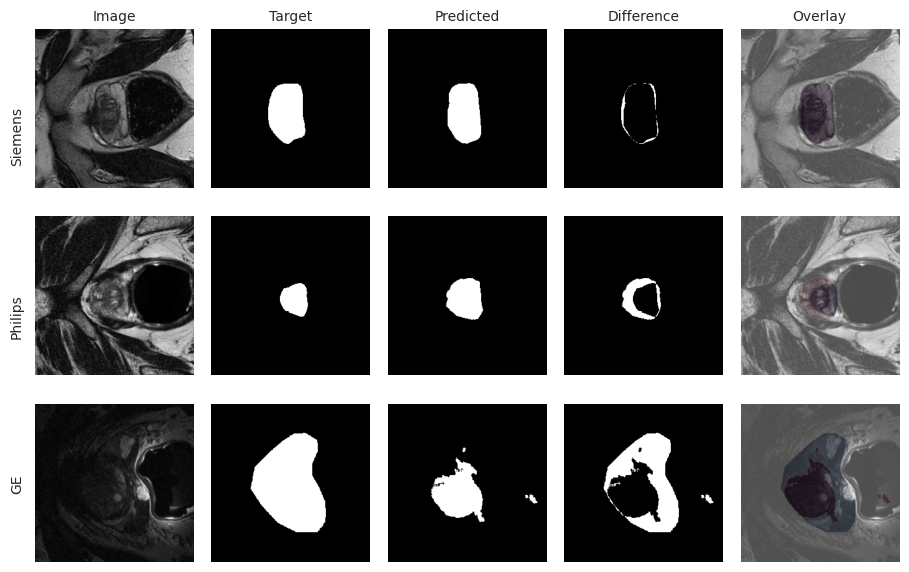

In [15]:
plot_idx(97, 122, 116)

siemens 30
siemens 0.9628461
ge 67
ge 0.077892326


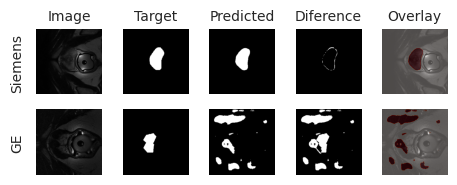

In [12]:
plot_idx_2(30, 67)

/tmp/ipykernel_3971189/3525942386.py:17: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.boxplot(x='Model', y='Dice', hue='Vendor', data=df, palette=palette)


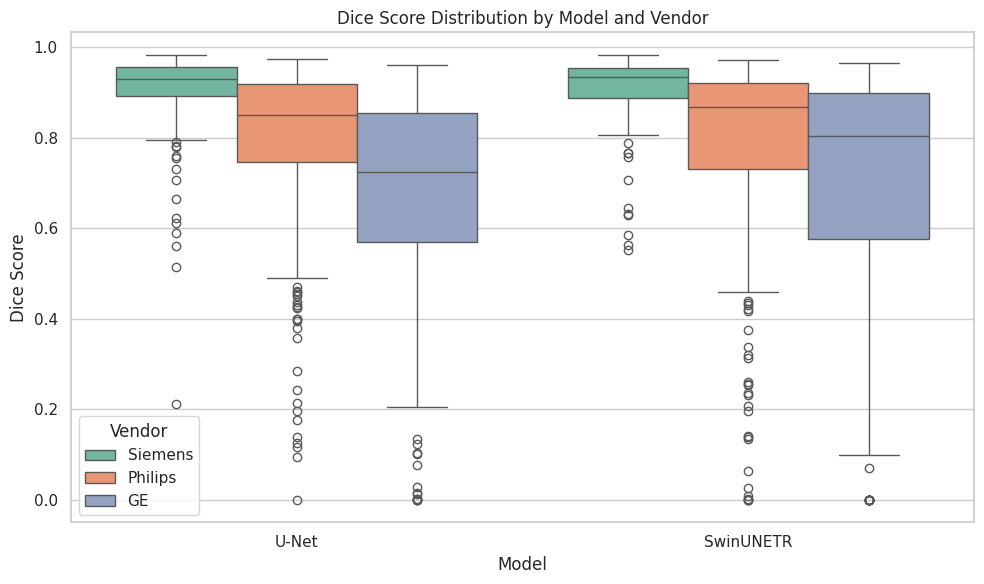

In [5]:
boxplotdata = []
for ven in test_vendors:
    for model in models:
        for d in dices_vendor[ven][model]['DS']:
            boxplotdata.append(
                {
                    "Vendor": ven.capitalize() if ven != "ge" else "GE",
                    "Model": "U-Net" if "monai" in model else "SwinUNETR",
                    "Dice": d
                }
            )

df = pd.DataFrame(boxplotdata)
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2")
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Dice', hue='Vendor', data=df, palette=palette)

# Customize the plot
plt.title('Dice Score Distribution by Model and Vendor')
plt.xlabel('Model')
plt.ylabel('Dice Score')
plt.legend(title='Vendor')

# Show the plot
plt.tight_layout()
plt.show()
        

In [4]:
pcas_path = "/workspace/out/dms"
stats_path = "/workspace/out/eval_data"
pmri_df_mahal = pd.read_csv(f"{stats_path}/mahal_dist_stats.csv")
pmri_df_metr = pd.read_csv(f"{stats_path}/dim_ent_stats.csv")
with open(f"{stats_path}/model_stats.json", "r") as f:
    pmri_model_stats = json.load(f)

In [5]:
data_key = "prostate"
model = "monai-64-4-4"
with open(f"{pcas_path}/{data_key}_{model}_{monai_iter}_base_PCA_model_0_conv.pkl", "rb") as f:
    pca_unet = pickle.load(f)

In [14]:
pca_unet.explained_variance_ratio_[1]

0.06105721

In [12]:
len(pca_unet.explained_variance_ratio_[1::2])

480

In [32]:
def plot_pca_exp_variance(pca):
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)

    # Create a range for the number of components
    # num_components = np.array([2**i for i in range(10)])
    num_components = np.arange(2, len(explained_variance) + 1, 2)

    # Set seaborn style
    sns.set(style="whitegrid")

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=num_components, y=cumulative_explained_variance[1::2], color="b")
    num_components = np.array([2**i for i in range(1,9)] + [960])
    sns.scatterplot(x=num_components, y=cumulative_explained_variance[num_components - 1], marker="o", color="b")

    # Add titles and labels
    plt.title('Explained Variance vs Number of Components (U-Net PCA adapted, layer 1)', fontsize=12)
    plt.xlabel('Number of Components', fontsize=10)
    plt.ylabel('Explained Variance Ratio', fontsize=10)
    plt.xticks([2, 128, 256, 512, 960])

    # Add grid, legend, and axis limits
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

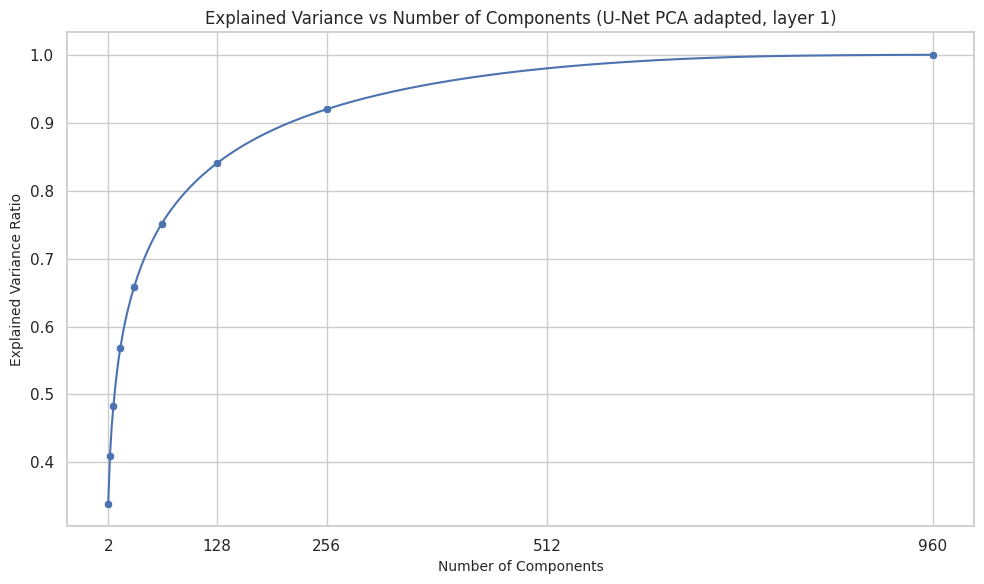

In [33]:
plot_pca_exp_variance(pca_unet)

In [3]:
def print_stats(df):
    print("\nAuroc mean per layer & model\n")
    print(df.groupby(['model', 'layer'])['auroc'].mean().reset_index())
    print("\nAuroc mean per num_dims & model\n")
    print(df.groupby(['model', 'n_dims'])['auroc'].mean().reset_index())
    print("\nAuroc mean per dim reduction method\n")
    print(df[df.n_dims > 4].groupby('dim_red_mode')['auroc'].mean().reset_index())
    print("\nAuroc mean IPCA vs PCA comparison\n")
    print(df[df.n_dims <= 4].groupby(['dim_red_mode', 'n_dims'])['auroc'].mean().reset_index().sort_values(by="n_dims"))
    print("\nAuroc mean per dim reduction method and n_dims\n")
    print(df.groupby(['dim_red_mode', 'n_dims'])['auroc'].mean().reset_index().sort_values(by="auroc", ascending=False))
    print("\nAuroc mean by vendor\n")
    print(df.groupby(['vendor', 'model'])['auroc'].mean().reset_index().sort_values(by="auroc", ascending=False))
    print("\nAuroc mean by vendor and method\n")
    print(df.groupby(['vendor', 'dim_red_mode'])['auroc'].mean().reset_index().sort_values(by="auroc", ascending=False))

In [10]:
def print_stats_anomaly(df, word):
    print(df.groupby(['model', 'dim_red_mode', 'n_dims', 'vendor'])[f'auroc_5_{word}', f'auroc_10_{word}', f'auroc_95_{word}'].mean().reset_index().sort_values(by=f"auroc_5_{word}", ascending=False))